# Associations of the microbial fecal proteome and high-fat diet induced weight gain


Metaproteomic Analysis<br><br>
By Robert Mills <br>
8/10/2018<br>
Python3 Environment<br>
<br>
<b>Project Abstract:</b><br>
Determinants of proneness to obesity upon availability of energy-dense diets are complex and poorly understood. Indeed, mouse models of diet-induced obesity (DIO) in mice exhibit wide intra-experimental heterogeneity in weight gain and adiposity, even amongst mice with nearly uniform genetics. Here, we sought to broadly characterize parameters that might predict and/or correlate with extent of weight gain in response to a high-fat diet (HFD). We measured metabolic parameters, behavior, inflammatory markers/cytokines, microbiota composition via 16S sequencing, and fecal proteomics by NMR-LC/MS prior to and following exposure to HFD. We hypothesized that pre-existing inflammation might predispose to HFD-induced obesity, possibly by impacting the gut-brain axis and subsequently behavior. However, neither the inflammatory markers nor behavioral testing showed clear capacity to distinguish mice that were highly prone vs. relatively resistant to HFD, although elevations in serum IL-6 marked a subset of mice that were prone to HFD-induced adiposity. Fecal microbiota composition and proteome both changed markedly in response to HFD but did not show strong unsupervised ability to distinguish prone vs. resistant mice. Nonetheless, fecal proteome analysis did reveal functional classes or proteins and classes of bacteria that correlated with HFD proneness. Such associations were tested by targeted interrogation of 16S data and largely confirmed indicating they were unlikely technical artifacts and, rather, reflected true correlations of fecal proteins and HFD-induced weight gain in our study. While future work will be needed to determine the breadth of applicability of these associations to other cohorts of animals and humans, this study nonetheless highlights the potential power of gut microbial proteins to impact obesity.



### Load Dependencies

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy
import math
import seaborn as sns
from scipy.stats import ttest_ind
import re
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Makes plots inline. This is prefered by the jupyter team
% matplotlib inline
# Sets your seaborn plot style. See: http://seaborn.pydata.org/tutorial/aesthetics.html
sns.set(style= 'white', color_codes=True)

### User-defined functions

This function will perform a series of t-test's for each protein within our dataset. Inputs include the original dataframe, df, and the two subsetted dataframes you want to compare, ttdf1 and ttdf2.

In [4]:
ttests=[]
def ttest(df,ttdf1,ttdf2):
    from scipy.stats import ttest_ind
    ttdf1 = ttdf1.transpose()
    ttdf2 = ttdf2.transpose()
    ttests = ttest_ind(ttdf1,ttdf2,equal_var=False,nan_policy='omit')
    ttests = ttests.pvalue.transpose()
    df['ttest_pvalue']=ttests

This function will create and save a volcano plot, which is a useful way of visualizing your most significant changing proteins when comparing two different groupings. Volcano plots use the significance (through p-values) and fold change between the two groups to help reduce false discoveries.

The function requires the dataframe you are performing the plot on, df; a subset of the original dataframe which you have classified as significant, significantdf; a column name within both of these dataframes where the fold change values are located, foldchange; a column name within both of these dataframes where the pvalues are stored, pvalue; and a string name for saving the plot, savename

In [5]:
def volcanotop10(df, significantdf,top10high,top10low,foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=8, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=50, label='Significant')
    plt.scatter(top10high['%s' % (foldchange)], top10high['%s' % (pvalue)], c='r', s=35, label='Top 10 Initial Enriched')
    plt.scatter(top10low['%s' % (foldchange)], top10low['%s' % (pvalue)], c='b', s=35, label='Top 10 Final Enriched')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    savefig('%s' % (savename))

In [6]:
def volcanosig(significantdf, foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    #plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=50, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=50, label='Significant')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    plt.savefig('%s' % (savename))

In [7]:
def volcano(df, significantdf, foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=20, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=50, label='Significant')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    plt.savefig('%s' % (savename))

In [8]:
def fold(df, sub1, sub2, sub1name, sub2name):
    df['%s Mean' % (sub1name)]=sub1.mean(axis=1,skipna=True)
    df['%s Mean' % (sub2name)]=sub2.mean(axis=1,skipna=True)
    df['Fold Change(%s/%s)' % (sub1name,sub2name)]=df['%s Mean' % (sub1name)]/df['%s Mean' % (sub2name)]
    print("Fold Change Column Name = 'Fold Change(%s/%s)'" %(sub1name,sub2name))
    

In [9]:
def piscore(df,sub1name,sub2name):
    df['Log2(Fold Change)'] = log2(df['Fold Change(%s/%s)'% (sub1name,sub2name)])
    df['-Log(P-value)'] = -np.log10(df['ttest_pvalue'])
    df['%s/%s pi score' % (sub1name,sub2name)] = df['-Log(P-value)']*df['Log2(Fold Change)']

In [10]:
def TwoCategoryMaster(dfmain,dfsub1,dfsub2,sub1name,sub2name):
    ttest(dfmain,dfsub1,dfsub2)
    fold(dfmain,dfsub1,dfsub2,sub1name,sub2name)
    piscore(dfmain,sub1name,sub2name)

### Load in the data

We have several files to consider using, but for these analyses I will use the common to all file, and name it df for short here.

In [26]:
#This file has data before adding functions - also includes host proteins
df2 = pd.read_csv("./Diet_Response_Metaproteomics/Data/NormalizedCommonReps.txt", sep='\t')

#This file has the bacterial proteins with annotations only
df = pd.read_csv('./HFDiet_CommonReps_SplitTaxa_Funcs.csv')

In [74]:
#Subsetting out proteins without annotations in the SplitTaxa file - used for obtaining mouse gene annotations
ls = list(df['datarest$ProteinID'])
df2[~df2['datarest$ProteinID'].isin(ls)].to_csv('./HFDiet_CommonReps_NoBacFunction.csv')

In [75]:
HostAnn = pd.read_csv('./Mouse_Functions.txt', sep = '\t', index_col = 'Entry')

In [27]:
#Provided annotation information from database website
taxa = pd.read_csv("./Diet_Response_Metaproteomics/Mouse Gut Gene Catalog/184sample.uniq_gene.NR.anno.merge.txt", sep='\t')
KO = pd.read_csv("./Diet_Response_Metaproteomics/Mouse Gut Gene Catalog/184sample.uniq_gene.KAAS.anno.txt", sep='\t')
eggNOG = pd.read_csv("./Diet_Response_Metaproteomics/Mouse Gut Gene Catalog/184sample.uniq_gene.eggNOG3.anno.txt", sep='\t')

In [28]:
#Annotate COG Categories
COG = pd.read_csv('./COG.description.csv')
COG.columns = ['COG', 'COG Protein Name']
COG_cats = pd.read_csv('./COG.funccat.csv')
COG_cats.columns = ['COG', 'eggNOG_Code']
Cat_key = pd.read_csv('./eggNOG_FunCats.csv')

In [29]:
#Merge the annotation information to annotate the protein
df = df.merge(taxa, left_on="datarest$ProteinID", right_on="Protein")
df =  df.merge(KO, left_on="datarest$ProteinID", right_on="Protein")
df = df.merge(eggNOG, left_on="datarest$ProteinID", right_on="Protein")

In [30]:
#Add eggNOG annotations
merge3 = df.merge(COG, left_on = 'eggNOG3_y', right_on = 'COG', how = 'left')

In [108]:
#Annotate mouse genes
df2 = df2.merge(HostAnn, left_on = 'datarest$ProteinID', right_index = True)

In [109]:
df2.to_csv('./HFDiet_CommonReps_Mouse_Annotations.csv')

In [13]:
#Save the dataframe with all the annotation information as a csv
df.to_csv("./Diet_Response_Full_Annotations.csv")

### Biological Replicate Cluster Map

In [31]:
df = merge3

In [12]:
#Create a correlation matrix using spearman as the method
corr= df.corr(method="spearman")

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


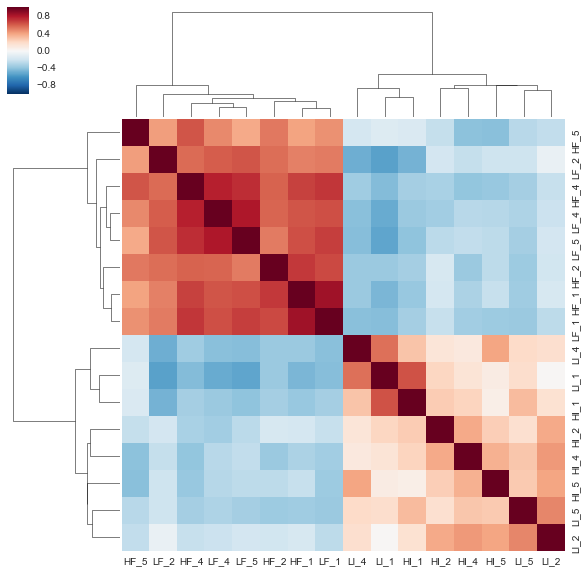

In [13]:
#Create a seaborn clustermap
sns.clustermap(corr)
savefig("HFDiet_Technical_Correlation_Plot.pdf")

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


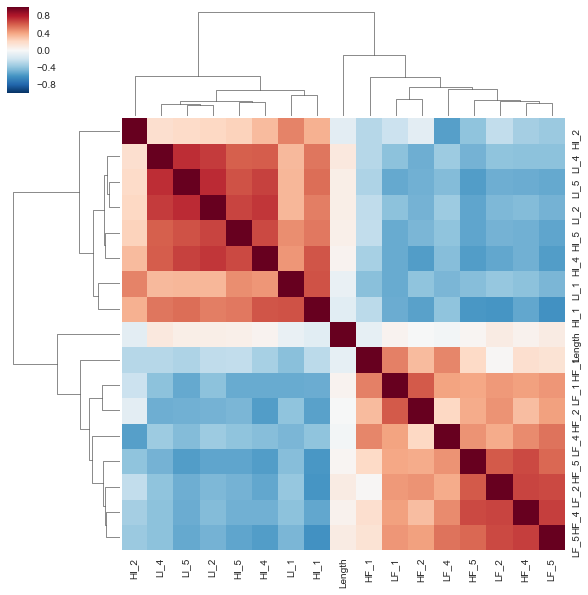

In [77]:
#Create a correlation matrix using spearman as the method
corr= df2.corr(method="spearman")
#Create a seaborn clustermap
sns.clustermap(corr)
savefig("HFDiet_Technical_Correlation_Plot_mouseproteins.pdf")

## KMeans Comparisons

In [40]:
df = pd.read_csv('./HFDiet_CommonReps_SplitTaxa_Funcs_KMeans6.csv', index_col = "datarest$ProteinID")

,HF_1,LI_1,HI_5,LF_1,HI_2,LF_4,HF_4,LF_5,LI_4,HI_1,...,family,genus,species,9,COG,Protein_y,eggNOG_Code,eggNOG Functional Assignment,eggNOG Subgroup,Description
datarest$ProteinID,,,,,,,,,,,,,,,,,,,,,
1-1_GL0042165,164.313402,227.928793,285.518083,158.802672,138.689067,273.108966,253.064317,139.037092,232.272613,278.675572,...,NaN,NaN,NaN,NaN,COG1012,NAD-dependent aldehyde dehydrogenases,C,C,Metabolism,Energy production and conversion
1-1_GL0112732,95.772087,140.712574,246.936697,108.044929,426.399905,112.156578,99.369700,112.201128,167.062825,163.268051,...,NaN,NaN,NaN,NaN,COG2086,"Electron transfer flavoprotein, beta subunit",C,C,Metabolism,Energy production and conversion
10_GL0015261,59.245986,112.933403,147.417880,65.063754,380.552932,42.395503,82.824424,88.973686,104.728233,218.241759,...,NaN,NaN,NaN,NaN,COG1866,Phosphoenolpyruvate carboxykinase (ATP),C,C,Metabolism,Energy production and conversion
17_GL0006542,63.249275,249.270051,88.397687,91.331128,168.830976,261.773595,68.851906,128.641449,64.142698,153.380039,...,NaN,NaN,NaN,NaN,COG1012,NAD-dependent aldehyde dehydrogenases,C,C,Metabolism,Energy production and conversion
1A-dyr1-07_GL0022475,126.652006,70.658193,387.769585,171.816523,116.771036,214.290330,181.252441,373.387759,311.709800,128.728189,...,NaN,NaN,NaN,NaN,COG0716,Flavodoxins,C,C,Metabolism,Energy production and conversion
1A-dyr1-07_GL0025046,34.109483,89.233484,513.945362,42.800525,357.946897,46.506943,49.227526,81.845667,120.568153,144.371547,...,NaN,NaN,NaN,NaN,COG1804,Predicted acyl-CoA transferases/carnitine dehy...,C,C,Metabolism,Energy production and conversion
1A-dyr1-07_GL0029133,69.385264,87.731669,604.988956,22.765167,180.886662,46.533453,26.522569,46.747702,389.399357,188.221618,...,NaN,NaN,NaN,NaN,COG0831,Urea amidohydrolase (urease) gamma subunit,E,E,Metabolism,Amino acid transport and metabolism
1A-dyr1-07_GL0039913,32.603904,112.773025,779.129904,14.317802,152.874757,24.440972,19.729630,34.190609,219.308577,95.280053,...,NaN,NaN,NaN,NaN,COG2077,Peroxiredoxin,O,O,Cellular processes and signaling,"Posttranslational modification, protein turnov..."
1A-dyr2-07_GL0010453,103.474214,133.260309,148.350143,87.242892,748.231210,7.244395,142.446404,110.808664,131.148504,117.961248,...,NaN,NaN,NaN,NaN,COG0191,Fructose/tagatose bisphosphate aldolase,G,G,Metabolism,Carbohydrate transport and metabolism


In [58]:
Ks = [1,2,3,4,5,6]

In [61]:
df_count = df[samples].groupby([df['Description']]).count()
df_count['Percent'] = df_count['HI_1']/df_count['HI_1'].sum()

In [62]:
for i in Ks:
    df_kmeans = df[df['K_Means6'] == i]
    df_kmeans_count = df_kmeans[samples].groupby([df_kmeans['Description']]).count()
    df_kmeans_count['Percent'] = df_kmeans_count['HI_1']/df_kmeans_count['HI_1'].sum()
    df_count['KMeans%s/Total' %i] = df_kmeans_count['Percent']/df_count['Percent']

In [66]:
df_count.to_csv('./KMeans6_Functional_Differences.csv')

In [67]:
df_count = df[samples].groupby([df['All Taxa']]).count()
df_count['Percent'] = df_count['HI_1']/df_count['HI_1'].sum()

In [68]:
for i in Ks:
    df_kmeans = df[df['K_Means6'] == i]
    df_kmeans_count = df_kmeans[samples].groupby([df_kmeans['All Taxa']]).count()
    df_kmeans_count['Percent'] = df_kmeans_count['HI_1']/df_kmeans_count['HI_1'].sum()
    df_count['KMeans%s/Total' %i] = df_kmeans_count['Percent']/df_count['Percent']

In [70]:
df_count.to_csv('./All_taxa_Counts.csv')

## Taxonomic Plots

In [20]:
samples = ["HI_1","HI_2","HI_4","HI_5","LI_1","LI_2","LI_4","LI_5","HF_1","HF_2","HF_4","HF_5","LF_1","LF_2","LF_4","LF_5"]

In [30]:
df['order']

0                      NaN
1                      NaN
2                      NaN
3                      NaN
4                      NaN
5                      NaN
6                      NaN
7                      NaN
8                      NaN
9                      NaN
10                     NaN
11                     NaN
12                     NaN
13                     NaN
14                     NaN
15                     NaN
16                     NaN
17                     NaN
18                     NaN
19                     NaN
20                     NaN
21                     NaN
22                     NaN
23                     NaN
24                     NaN
25                     NaN
26                     NaN
27                     NaN
28                     NaN
29                     NaN
               ...        
6281         Bacteroidales
6282    Verrucomicrobiales
6283    Verrucomicrobiales
6284    Verrucomicrobiales
6285    Verrucomicrobiales
6286    Verrucomicrobiales
6

In [32]:
dfcategories = df[samples].groupby([df.order]).agg(['sum'])
#dfcategories = df[samples].groupby([df.Description]).agg(['sum'])
dfcategories.columns = dfcategories.columns.droplevel(1)
dfcategories['Sum'] = dfcategories.sum(axis=1)

In [33]:
for i in samples:
    dfcategories[i] = dfcategories[i]/dfcategories[i].sum()

In [34]:
#Transpose the plot to make it fit the code structure I'm following for the stacked bar chart

#Remove index name
del dfcategories.index.name
#Transpose
dfcategories = dfcategories.transpose()
#Get the dates in the correct order
dfcategories = dfcategories.reindex(samples)
#Get Phyla into an order which depends on the abundance of each phyla for easier interpretation
dfcategories = dfcategories[dfcategories.sum().sort_values(ascending = False).index]

In [27]:
#Generate random colors
vals = np.linspace(0,1,23)
np.random.shuffle(vals)
my_cmap = plt.cm.colors.ListedColormap(plt.cm.Dark2(vals))

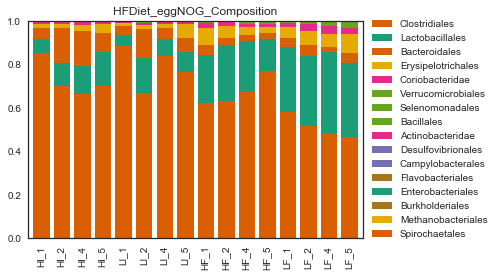

In [42]:
#Simple Plot
#my_cmap = plt.cm.colors.ListedColormap(plt.cm.Dark2(vals2))
#my_cmap = plt.cm.get_cmap('my_cmap')
plot1 = dfcategories.plot(kind='bar', width = 0.8, stacked=True, colormap=my_cmap, title='HFDiet_eggNOG_Composition')
plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plot1
#plt.savefig('HFDiet_eggNOG_Composition.pdf',bbox_inches="tight")

## Functions of eggNOG proteins

In [15]:
COG = pd.read_csv('COG.description.csv')
COG.columns = ['COG', 'Protein']

In [16]:
COG_cats = pd.read_csv('COG.funccat.csv')
COG_cats.columns = ['COG', 'eggNOG_Code']
Cat_key = pd.read_csv('eggNOG_FunCats.csv')

In [25]:
df = df.merge(COG, left_on = 'eggNOG3', right_on = 'COG', how = 'left')

KeyError: 'eggNOG3'

In [159]:
df = df.merge(COG_cats, left_on = 'COG', right_on = 'COG', how = 'left')

,datarest$ProteinID,HF_1,LI_1,HI_5,LF_1,HI_2,LF_4,HF_4,LF_5,LI_4,...,phylum,class,order,family,genus,species,9,COG,Protein_y,eggNOG_Code
0,1_GL0033988,50.874327,296.903132,129.684242,84.588508,246.184797,70.303792,54.234264,89.821195,202.847898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG4146,Predicted symporter,R
1,1_GL0066634,177.175833,60.803982,87.940756,227.188495,115.376168,536.634088,625.688961,350.719241,46.245954,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG1028,Dehydrogenases with different specificities (r...,IQR
2,1-1_GL0002373,317.722006,271.199204,170.773049,294.142885,151.685580,170.906741,143.606026,229.933479,157.239228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG0395,"ABC-type sugar transport system, permease comp...",G
3,1-1_GL0002951,31.558414,165.595442,120.241091,49.007663,391.914171,25.204066,30.793588,51.494542,96.865592,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG1653,"ABC-type sugar transport system, periplasmic c...",G
4,1-1_GL0024353,14.258328,44.290431,139.516738,15.737303,273.885502,11.073081,23.832487,41.466474,323.962822,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG0461,Orotate phosphoribosyltransferase,F
5,1-1_GL0031227,352.050096,90.098944,52.087124,279.054828,79.010526,378.168180,530.747231,109.083031,49.480352,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG1250,3-hydroxyacyl-CoA dehydrogenase,I
6,1-1_GL0031369,556.052236,238.943766,84.890827,417.503195,89.624986,180.091991,301.612171,229.934273,137.830656,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG2987,Urocanate hydratase,E
7,1-1_GL0034049,18.584567,57.699552,164.754408,2.780743,289.167995,2.017007,31.388151,57.069549,103.919168,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG0346,Lactoylglutathione lyase and related lyases,E
8,1-1_GL0038049,240.157282,508.674342,117.580170,119.457592,122.650664,91.039390,371.507686,51.122138,219.394149,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1-1_GL0042165,164.313402,227.928793,285.518083,158.802672,138.689067,273.108966,253.064317,139.037092,232.272613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG1012,NAD-dependent aldehyde dehydrogenases,C


In [160]:
df = df.merge(Cat_key, left_on = 'eggNOG_Code', right_on = 'eggNOG Functional Assignment', how = 'left')

,datarest$ProteinID,HF_1,LI_1,HI_5,LF_1,HI_2,LF_4,HF_4,LF_5,LI_4,...,family,genus,species,9,COG,Protein_y,eggNOG_Code,eggNOG Functional Assignment,eggNOG Subgroup,Description
0,1_GL0033988,50.874327,296.903132,129.684242,84.588508,246.184797,70.303792,54.234264,89.821195,202.847898,...,NaN,NaN,NaN,NaN,COG4146,Predicted symporter,R,R,Poorly Characterized,General function prediction only
1,1_GL0066634,177.175833,60.803982,87.940756,227.188495,115.376168,536.634088,625.688961,350.719241,46.245954,...,NaN,NaN,NaN,NaN,COG1028,Dehydrogenases with different specificities (r...,IQR,NaN,NaN,NaN
2,1-1_GL0002373,317.722006,271.199204,170.773049,294.142885,151.685580,170.906741,143.606026,229.933479,157.239228,...,NaN,NaN,NaN,NaN,COG0395,"ABC-type sugar transport system, permease comp...",G,G,Metabolism,Carbohydrate transport and metabolism
3,1-1_GL0002951,31.558414,165.595442,120.241091,49.007663,391.914171,25.204066,30.793588,51.494542,96.865592,...,NaN,NaN,NaN,NaN,COG1653,"ABC-type sugar transport system, periplasmic c...",G,G,Metabolism,Carbohydrate transport and metabolism
4,1-1_GL0024353,14.258328,44.290431,139.516738,15.737303,273.885502,11.073081,23.832487,41.466474,323.962822,...,NaN,NaN,NaN,NaN,COG0461,Orotate phosphoribosyltransferase,F,F,Metabolism,Nucleotide transport and metabolism
5,1-1_GL0031227,352.050096,90.098944,52.087124,279.054828,79.010526,378.168180,530.747231,109.083031,49.480352,...,NaN,NaN,NaN,NaN,COG1250,3-hydroxyacyl-CoA dehydrogenase,I,I,Metabolism,Lipid transport and metabolism
6,1-1_GL0031369,556.052236,238.943766,84.890827,417.503195,89.624986,180.091991,301.612171,229.934273,137.830656,...,NaN,NaN,NaN,NaN,COG2987,Urocanate hydratase,E,E,Metabolism,Amino acid transport and metabolism
7,1-1_GL0034049,18.584567,57.699552,164.754408,2.780743,289.167995,2.017007,31.388151,57.069549,103.919168,...,NaN,NaN,NaN,NaN,COG0346,Lactoylglutathione lyase and related lyases,E,E,Metabolism,Amino acid transport and metabolism
8,1-1_GL0038049,240.157282,508.674342,117.580170,119.457592,122.650664,91.039390,371.507686,51.122138,219.394149,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1-1_GL0042165,164.313402,227.928793,285.518083,158.802672,138.689067,273.108966,253.064317,139.037092,232.272613,...,NaN,NaN,NaN,NaN,COG1012,NAD-dependent aldehyde dehydrogenases,C,C,Metabolism,Energy production and conversion


In [161]:
df.to_csv('./HFDiet_CommonReps_SplitTaxa_Funcs.csv')

In [19]:
df.columns

Index(['Unnamed: 0', 'datarest$ProteinID', 'HF_1', 'LI_1', 'HI_5', 'LF_1',
       'HI_2', 'LF_4', 'HF_4', 'LF_5', 'LI_4', 'HI_1', 'LI_5', 'HF_2', 'LF_2',
       'HF_5', 'LI_2', 'HI_4', 'Gene Name', 'unknown_x', 'Best Taxa_x',
       'Best Classification_x', 'All Taxa_x', 'Known Taxa', 'KO_x',
       'Protein_x', 'Name_x', 'eggNOG3_x', 'root', 'Organism Type',
       'superkingdom', 'phylum', 'class', 'order', 'family', 'genus',
       'species', '9', 'COG', 'Protein_y', 'eggNOG_Code',
       'eggNOG Functional Assignment', 'eggNOG Subgroup', 'Description',
       'Protein_x', 'unknown_y', 'Best Taxa_y', 'Best Classification_y',
       'All Taxa_y', 'Unknown2', 'Protein_y', 'KO_y', 'Protein', 'Name_y',
       'eggNOG3_y'],
      dtype='object')

# Determining Proteins of Interest

### Proteins altered with high fat diet

In [104]:
df = pd.read_csv("./HFDiet_CommonReps_SplitTaxa_Funcs.csv")

In [41]:
#Microbiome
#I = df[["HI_1","HI_2","HI_4","HI_5","LI_1","LI_2","LI_4","LI_5"]]
#F = df[["HF_1","HF_2","HF_4","HF_5","LF_1","LF_2","LF_4","LF_5"]]

#Mouse gut proteins
#df = df2
I = df[["HI_1","HI_2","HI_4","HI_5","LI_1","LI_2","LI_4","LI_5"]]
F = df[["HF_1","HF_2","HF_4","HF_5","LF_1","LF_2","LF_4","LF_5"]]

In [42]:
#Using TwoCategoryMaster function, we can perform a ttest as well as several other statistical tests commonly used when comparing two categories in proteomic datasets
TwoCategoryMaster(df,I,F,'Initial','Final')

Fold Change Column Name = 'Fold Change(Initial/Final)'


In [83]:
#Save host protein significance dataframe
df.to_csv('./Host_protein_IntialFinalTime_Significance.csv')

In [43]:
#Determine significant proteins, setting significance to piscore > 1
df_sign= df[abs(df['Initial/Final pi score']) > 1]

In [44]:
dfI = df_sign[df_sign['Initial/Final pi score'] > 0]
dfF = df_sign[df_sign['Initial/Final pi score'] < 0]

In [45]:
#Use this code if you want to look at quantity of significant proteins
dfI['Final'] = 0
dfF['Final'] = 1
dfI['Initial'] = 1
dfF['Initial'] = 0

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [46]:
#Use this code if you want to simply look at quantity of significant proteins
df_sig = pd.concat([dfI, dfF])

In [47]:
df_sig.columns

Index(['Unnamed: 0', 'datarest$ProteinID', 'HF_1', 'LI_1', 'HI_5', 'LF_1',
       'HI_2', 'LF_4', 'HF_4', 'LF_5', 'LI_4', 'HI_1', 'LI_5', 'HF_2', 'LF_2',
       'HF_5', 'LI_2', 'HI_4', 'Gene Name', 'unknown', 'Best Taxa',
       'Best Classification', 'All Taxa', 'Known Taxa', 'KO', 'Protein_x',
       'Name', 'eggNOG3', 'root', 'Organism Type', 'superkingdom', 'phylum',
       'class', 'order', 'family', 'genus', 'species', '9', 'COG', 'Protein_y',
       'eggNOG_Code', 'eggNOG Functional Assignment', 'eggNOG Subgroup',
       'Description', 'ttest_pvalue', 'Initial Mean', 'Final Mean',
       'Fold Change(Initial/Final)', 'Log2(Fold Change)', '-Log(P-value)',
       'Initial/Final pi score', 'Final', 'Initial'],
      dtype='object')

In [49]:
#Use this for eggNOG category
dfcategories = df_sig[['Final','Initial']].groupby([df_sig['Description']]).agg(['sum'])

#dfcategories = df_sig[['Final','Initial']].groupby([df_sig['order']]).agg(['sum'])
dfcategories.columns = dfcategories.columns.droplevel(1)

In [50]:
#Add a Pseudocount of 1 so that the categories without anything are still shown
#dfcategories = dfcategories.replace(0,1)
dfcategories

,Final,Initial
Description,,
Amino acid transport and metabolism,137,156
Carbohydrate transport and metabolism,313,663
"Cell cycle control, cell division, chromosome partitioning",7,1
Cell motility,3,141
Cell wall/membrane/envelope biogenesis,32,18
Coenzyme transport and metabolism,12,13
Defense mechanisms,5,6
Energy production and conversion,126,192
Function unknown,9,5


In [52]:
#Find the ratios necessary for calculating the ratio of ratios
dfcategories['Percent_Initial'] = \
dfcategories['Initial']/dfcategories['Initial'].sum()
dfcategories['Percent_Final'] = \
dfcategories['Final']/dfcategories['Final'].sum()

In [53]:
dfcategories['Ratio of Percentages (Final/Initial)'] = dfcategories['Percent_Final']/dfcategories['Percent_Initial']

,Final,Initial,Percent_Initial,Percent_Final,Ratio of Percentages (Final/Initial)
Description,,,,,
Amino acid transport and metabolism,137,156,0.083646,0.105873,1.265728
Carbohydrate transport and metabolism,313,663,0.355496,0.241886,0.680417
"Cell cycle control, cell division, chromosome partitioning",7,1,0.000536,0.005410,10.088872
Cell motility,3,141,0.075603,0.002318,0.030665
Cell wall/membrane/envelope biogenesis,32,18,0.009651,0.024730,2.562253
Coenzyme transport and metabolism,12,13,0.006971,0.009274,1.330401
Defense mechanisms,5,6,0.003217,0.003864,1.201056
Energy production and conversion,126,192,0.102949,0.097372,0.945832
Function unknown,9,5,0.002681,0.006955,2.594281


In [54]:
dfcategories.to_csv('./FinalvsInitial_eggNOG_Ratios.csv')

In [132]:
#Transpose the plot to make it fit the code structure I'm following for the stacked bar chart

#Remove index name
del dfcategories.index.name
#Sort samples by time
order=['Percent_Initial', 'Percent_Final']
#Transpose
dfcategories = dfcategories.transpose()
#Get the dates in the correct order
dfcategories = dfcategories.reindex(order)
#Get Phyla into an order which depends on the abundance of each phyla for easier interpretation
dfcategories = dfcategories[dfcategories.sum().sort_values(ascending = False).index]

In [133]:
#Generate random colors
vals = np.linspace(0,1,15)
np.random.shuffle(vals)
my_cmap = plt.cm.colors.ListedColormap(plt.cm.Dark2(vals))

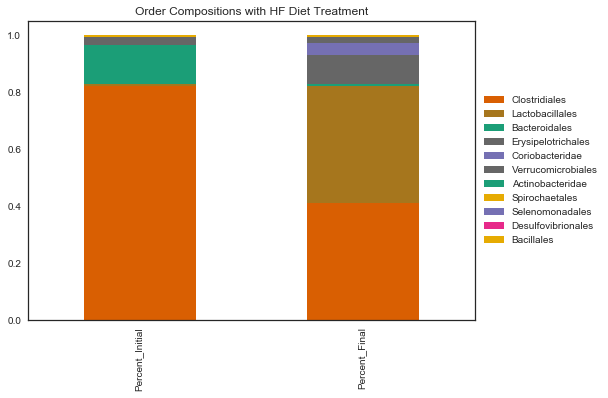

In [136]:
#Simple Plot
#my_cmap = plt.cm.get_cmap('Vega20')
plot1 = dfcategories.plot(kind='bar',stacked=True, colormap=my_cmap, title='Order Compositions with HF Diet Treatment')
plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('HFDiet_Sigpi1_Treatment_Order_Compositions.pdf',bbox_inches="tight")

### Comparing significant proteins from different responses

In [110]:
df = pd.read_csv('./HFDiet_CommonReps_SplitTaxa_Funcs.csv')
#df = pd.read_csv('./HFDiet_CommonReps_Mouse_Annotations.csv')

In [14]:
#Editing the function to new analysis type - just switching the titles.
def volcanotop10(df, significantdf,top10high,top10low,foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=8, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=50, label='Significant')
    plt.scatter(top10high['%s' % (foldchange)], top10high['%s' % (pvalue)], c='r', s=35, label='Top 10 High Responder Enriched')
    plt.scatter(top10low['%s' % (foldchange)], top10low['%s' % (pvalue)], c='b', s=35, label='Top 10 Low Responder Enriched')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    savefig('%s' % (savename))

In [15]:
#Editing the function to new analysis type - just switching the titles.
def volcanoIG(df, significantdf,IGdf,foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=50, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=100, label='Significant')
    plt.scatter(IGdf['%s' % (foldchange)], IGdf['%s' % (pvalue)], c='r', s=100, label='Significant IG')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    savefig('%s' % (savename))

In [16]:
sigIGs = ["A0A0A6YXN5","P01592","A0A0A6YXZ4","P01633","A0A075B666","P28665","A0A075B5V5","A0A0A6YX66","A0A0B4J1I8","A0A140T8Q3","P01728","A0A075B5X3","P18531","A0A075B5V6","A0A075B5M1","A0A140T8P6","P01662","A0A0G2JDN5","A0A075B5W9","A0A0G2JE47","A0A075B5P9","A0A0G2JFE9","A0A075B5T3","A0A075B5N7","A0A0A6YXJ9","A0A075B5W3","A0A075B5Y5","A0A075B5V0","A0A140T8N5","A0A0G2JGS9","A0A0A6YY41","A0A140T8N3","P01727","A0A0G2JGK2","A0A0B4J1J5","A0A0A6YWX0","A0A0B4J1P4","A0A075B5Q2","A0A0G2JEI6","A0A075B5L1"]

In [25]:
#Save dataframe with just the significant IGs
df[df['datarest$ProteinID'].isin(sigIGs)].to_csv('./SignificantIGs_InitialPiScores.csv')

In [17]:
len(sigIGs)

40

In [55]:
#Reload the data
#df = pd.read_csv("./Diet_Response_Metaproteomics/Data/NormalizedCommonReps.txt", sep='\t')
#df = pd.read_csv("./HFDiet_SplitTaxa.csv")
df = pd.read_csv('./HFDiet_CommonReps_SplitTaxa_Funcs.csv')

#Merge the annotation information to annotate the protein
df = df.merge(taxa, left_on="datarest$ProteinID", right_on="Protein")
df =  df.merge(KO, left_on="datarest$ProteinID", right_on="Protein")
df = df.merge(eggNOG, left_on="datarest$ProteinID", right_on="Protein")

In [111]:
#Use this for final timepoint
#HF=df[["HF_1","HF_2","HF_4","HF_5"]]
#LF=df[["LF_1","LF_2","LF_4","LF_5"]]

#Use this for initial timepoint
HF=df[["HI_1","HI_2","HI_4","HI_5"]]
LF=df[["LI_1","LI_2","LI_4","LI_5"]]

#Use this for general response
#LF = df[["HI_1","HI_2","HI_4","HI_5","LI_1","LI_2","LI_4","LI_5"]]
#HF = df[["HF_1","HF_2","HF_4","HF_5","LF_1","LF_2","LF_4","LF_5"]]

In [112]:
TwoCategoryMaster(df,HF,LF,'High Response Final','Low Response Final')

Fold Change Column Name = 'Fold Change(High Response Final/Low Response Final)'


In [113]:
#Save output
#df.to_csv("Responders_FinalTime_piscores.csv")
#df.to_csv("Responders_FinalTime_mouse_piscores.csv")

df.to_csv("Responders_InitialTime_piscores.csv")
#df.to_csv("Responders_InitialTime_mouse_piscores.csv")

#df.to_csv("Overall_InitialFinal_mouse_piscores.csv")

In [67]:
#Create lists and dataframes of the top 10 proteins for the top responders to high fat diet.
top10 = df['High Response Final/Low Response Final pi score'].nlargest(20)
low10 = df['High Response Final/Low Response Final pi score'].nsmallest(20)

top10df = df[df['High Response Final/Low Response Final pi score'].isin(top10)]
low10df = df[df['High Response Final/Low Response Final pi score'].isin(low10)]

In [68]:
#Get the Fold Change STD and subset out the significant hits (Top Responders)
#Fold_Change_STD = df['Log2(Fold Change)'].std()
#df_sign= df[abs(df['High Response Final/Low Response Final pi score']) > 1.5]

df_sign= df[abs(df['High Response Final/Low Response Final pi score']) > 1]


In [21]:
IG_df = df[df['datarest$ProteinID'].isin(sigIGs)]
IG_df

,Unnamed: 0,datarest$ProteinID,HF_1,LI_1,HI_5,LF_1,HI_2,LF_4,HF_4,LF_5,...,Function [CC],EC number,Subcellular location [CC],ttest_pvalue,High Response Final Mean,Low Response Final Mean,Fold Change(High Response Final/Low Response Final),Log2(Fold Change),-Log(P-value),High Response Final/Low Response Final pi score
2,6833,A0A075B5L1,540.942004,142.363412,219.655046,360.360028,201.388406,151.129764,408.022522,137.550301,...,NaN,NaN,NaN,0.005097,212.942531,71.217029,2.990051,1.580170,2.292708,3.622868
3,6834,A0A075B5M1,351.827517,95.129424,437.940622,158.037826,291.383791,72.974893,113.296271,255.854616,...,NaN,NaN,NaN,0.113410,255.119708,91.625592,2.784372,1.477352,0.945350,1.396615
5,6836,A0A075B5N7,301.581648,132.830984,238.785014,296.198715,506.745067,178.610728,89.527008,291.366977,...,NaN,NaN,NaN,0.096999,280.413886,90.075302,3.113105,1.638354,1.013234,1.660036
7,6839,A0A075B5P9,164.089920,143.625975,204.388052,266.888625,279.443348,312.855105,205.034978,222.854684,...,NaN,NaN,NaN,0.056348,184.984841,76.167215,2.428668,1.280165,1.249124,1.599084
8,6840,A0A075B5Q2,654.251466,30.819970,106.190725,496.661935,206.424544,125.682658,353.314704,208.951054,...,NaN,NaN,NaN,0.017299,162.423777,48.200373,3.369762,1.752647,1.761982,3.088131
16,6848,A0A075B5T3,444.967835,120.926110,212.728565,397.007230,362.438586,542.479647,163.623403,350.023340,...,NaN,NaN,NaN,0.068689,228.088558,85.399008,2.670857,1.417303,1.163115,1.648486
19,6851,A0A075B5V0,277.692585,95.476075,334.587942,273.682519,319.835661,189.765806,151.506983,214.740305,...,NaN,NaN,NaN,0.021454,274.474817,120.681027,2.274383,1.185475,1.668489,1.977952
20,6852,A0A075B5V5,226.884349,200.403869,59.842812,690.802896,902.056037,38.656541,68.113859,204.804401,...,NaN,NaN,NaN,0.311477,307.107188,63.012478,4.873752,2.285033,0.506574,1.157539
21,6853,A0A075B5V6,442.340464,98.639251,220.996375,416.154748,419.557689,194.678558,138.162625,231.164632,...,NaN,NaN,NaN,0.074407,256.085196,109.999814,2.328051,1.219123,1.128384,1.375639
22,6854,A0A075B5W3,441.073552,140.091473,206.173023,365.452346,299.983940,365.192063,184.943943,482.336983,...,NaN,NaN,NaN,0.021904,214.261115,99.653866,2.150053,1.104372,1.659480,1.832684


In [69]:
len(df_sign)

109

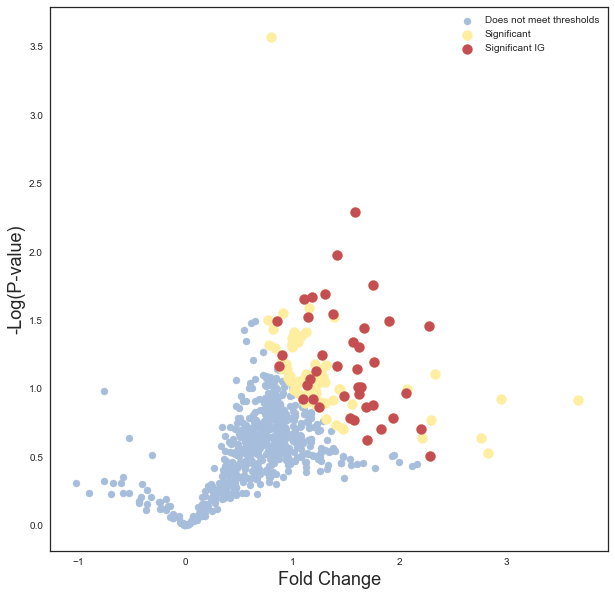

In [22]:
volcanoIG(df, df_sign,IG_df,'Log2(Fold Change)','-Log(P-value)', 'Responders_InitialTime_SigVolcano_Ig.pdf')

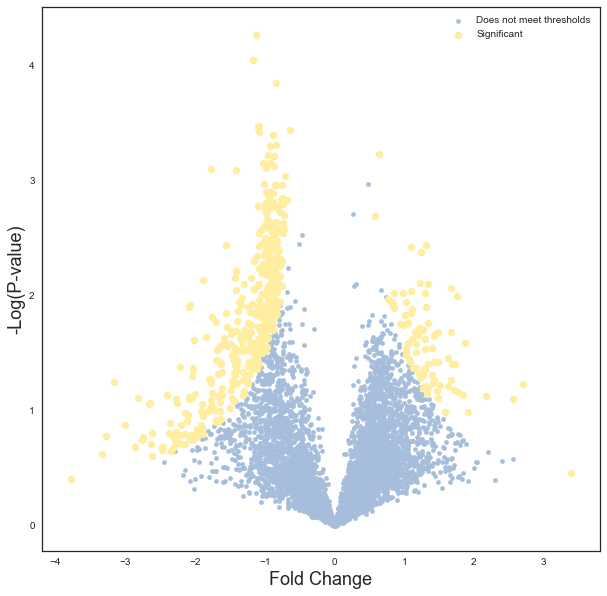

In [491]:
volcano(df, df_sign,'Log2(Fold Change)','-Log(P-value)', 'Responders_FinalTime_SigVolcano.pdf')

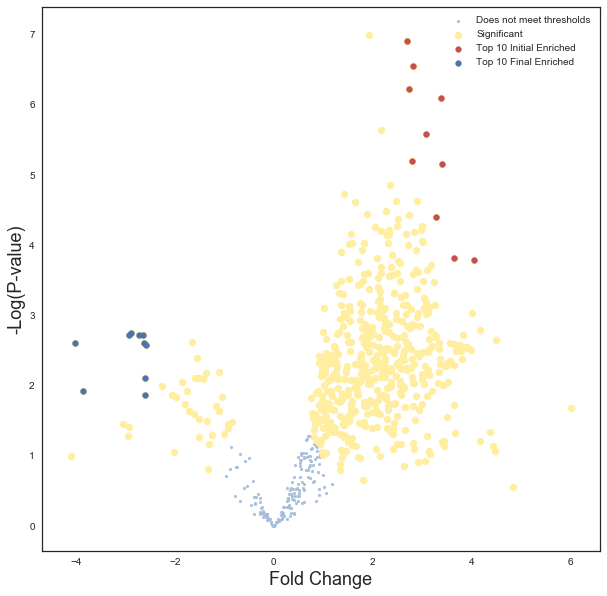

In [159]:
volcanotop10(df,df_sign,top10df,low10df,'Log2(Fold Change)','-Log(P-value)', 'Responders_InitialFinal_mouse_Volcano.pdf')

In [70]:
df.index=df['Protein names']
df

,Unnamed: 0,datarest$ProteinID,HF_1,LI_1,HI_5,LF_1,HI_2,LF_4,HF_4,LF_5,...,Function [CC],EC number,Subcellular location [CC],ttest_pvalue,High Response Final Mean,Low Response Final Mean,Fold Change(High Response Final/Low Response Final),Log2(Fold Change),-Log(P-value),High Response Final/Low Response Final pi score
Protein names,,,,,,,,,,,,,,,,,,,,,
Immunoglobulin kappa variable 14-126 (Fragment),6831,A0A075B5K0,251.286979,166.354467,116.069043,407.108637,386.037782,209.683044,143.540130,342.128203,...,NaN,NaN,NaN,0.484002,181.822747,124.940189,1.455278,0.541295,0.315153,0.170591
Immunoglobulin kappa variable 2-109 (Fragment),6832,A0A075B5K6,426.075771,44.492342,89.237666,352.366169,127.379657,535.742743,246.463351,442.564744,...,NaN,NaN,NaN,0.421703,189.267779,105.224733,1.798700,0.846955,0.374993,0.317602
Immunoglobulin kappa variable 10-94 (Fragment),6833,A0A075B5L1,540.942004,142.363412,219.655046,360.360028,201.388406,151.129764,408.022522,137.550301,...,NaN,NaN,NaN,0.005097,212.942531,71.217029,2.990051,1.580170,2.292708,3.622868
Immunoglobulin kappa variable 4-63,6834,A0A075B5M1,351.827517,95.129424,437.940622,158.037826,291.383791,72.974893,113.296271,255.854616,...,NaN,NaN,NaN,0.113410,255.119708,91.625592,2.784372,1.477352,0.945350,1.396615
Immunoglobulin kappa variable 4-57-1 (Fragment),6835,A0A075B5M4,379.378362,240.831934,55.176919,254.083745,389.674365,121.067273,229.252124,231.978074,...,NaN,NaN,NaN,0.228905,219.817967,106.741356,2.059351,1.042190,0.640344,0.667361
Immunoglobulin kappa variable 6-13,6836,A0A075B5N7,301.581648,132.830984,238.785014,296.198715,506.745067,178.610728,89.527008,291.366977,...,NaN,NaN,NaN,0.096999,280.413886,90.075302,3.113105,1.638354,1.013234,1.660036
Immunoglobulin heavy constant gamma 2B (Fragment),6838,A0A075B5P3,133.703934,52.329654,29.904155,240.743395,69.600701,629.553985,215.152934,2866.368076,...,NaN,NaN,NaN,0.543716,37.377436,27.174319,1.375469,0.459924,0.264628,0.121709
Immunoglobulin heavy variable 5-4 (Fragment),6839,A0A075B5P9,164.089920,143.625975,204.388052,266.888625,279.443348,312.855105,205.034978,222.854684,...,NaN,NaN,NaN,0.056348,184.984841,76.167215,2.428668,1.280165,1.249124,1.599084
Immunoglobulin heavy variable 5-9 (Fragment),6840,A0A075B5Q2,654.251466,30.819970,106.190725,496.661935,206.424544,125.682658,353.314704,208.951054,...,NaN,NaN,NaN,0.017299,162.423777,48.200373,3.369762,1.752647,1.761982,3.088131


In [74]:
top10 = df['High Response Final/Low Response Final pi score'].nlargest(20)
low10 = df['High Response Final/Low Response Final pi score'].nsmallest(20)

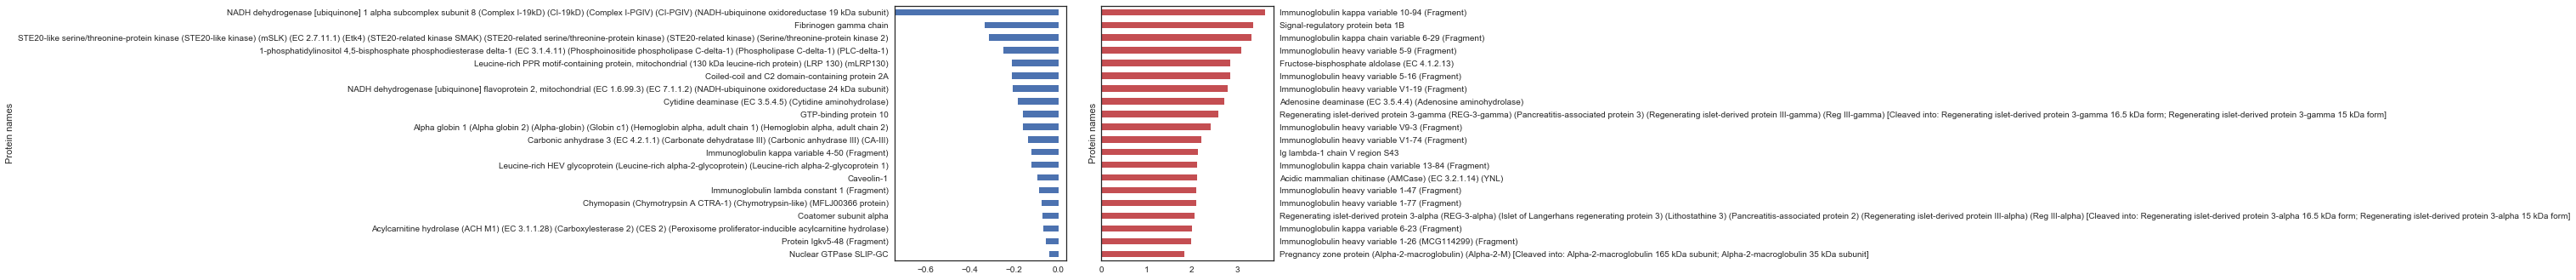

In [76]:
fig, axes = plt.subplots(ncols=2)

ax1 = top10.plot(kind='barh', color='r', ax=axes[1]).yaxis.tick_right()
ax2 = low10.plot(kind='barh', color='b', ax=axes[0]).invert_yaxis()
plt.gca().invert_yaxis()
savefig('Responders_Initial_mouse_top20proteins.pdf',bbox_inches='tight')

In [58]:
#Change your significance level if desired
df_sig = df[abs(df['High Response Final/Low Response Final pi score']) > 1]

,Unnamed: 0,datarest$ProteinID,HF_1,LI_1,HI_5,LF_1,HI_2,LF_4,HF_4,LF_5,...,eggNOG Functional Assignment,eggNOG Subgroup,Description,ttest_pvalue,High Response Final Mean,Low Response Final Mean,Fold Change(High Response Final/Low Response Final),Log2(Fold Change),-Log(P-value),High Response Final/Low Response Final pi score
17,17,1-1_GL0112732,95.772087,140.712574,246.936697,108.044929,426.399905,112.156578,99.369700,112.201128,...,C,Metabolism,Energy production and conversion,0.083303,327.863963,143.491621,2.284900,1.192131,1.079338,1.286712
18,18,1-1_GL0114159,207.929990,165.779388,110.147010,293.558833,97.844807,315.922751,106.626135,125.241162,...,E,Metabolism,Amino acid transport and metabolism,0.040892,109.110885,248.801391,0.438546,-1.189200,1.388362,-1.651039
32,32,1-2_GL0130701,618.023889,25.005193,96.643385,698.608536,63.787776,130.933946,1059.888708,567.668484,...,R,Poorly Characterized,General function prediction only,0.221704,46.327928,14.376077,3.222571,1.688212,0.654227,1.104474
68,68,1A-dyr1-07_GL0025046,34.109483,89.233484,513.945362,42.800525,357.946897,46.506943,49.227526,81.845667,...,C,Metabolism,Energy production and conversion,0.086124,447.190536,114.492753,3.905841,1.965633,1.064876,2.093155
81,81,1B-dyr11-07_GL0001131,1187.761693,2.246951,32.279043,894.013894,29.902249,606.945510,235.523352,616.182369,...,S,Poorly Characterized,Function unknown,0.288108,73.924612,12.370003,5.976119,2.579209,0.540444,1.393918
99,99,2-3_GL0008792,17.020028,269.574913,31.200682,41.855314,162.615250,5.016987,7.028764,28.208303,...,G,Metabolism,Carbohydrate transport and metabolism,0.149741,148.936109,411.740301,0.361723,-1.467041,0.824660,-1.209811
113,113,20_GL0075390,100.959703,125.615435,165.671857,86.866441,637.024358,38.338771,69.989098,79.399558,...,G,Metabolism,Carbohydrate transport and metabolism,0.172098,392.175574,157.713849,2.486627,1.314190,0.764223,1.004335
132,132,3-1_GL0078921,827.808599,130.243475,89.904527,389.752077,80.685485,370.282027,189.878585,414.171202,...,G,Metabolism,Carbohydrate transport and metabolism,0.019206,96.348943,195.935522,0.491738,-1.024038,1.716560,-1.757823
134,134,3-3_GL0014675,14.922003,363.898013,51.332562,19.681319,50.587968,27.996713,27.566901,37.376777,...,NaN,NaN,NaN,0.246259,32.392976,324.619295,0.099788,-3.324996,0.608609,-2.023621
139,139,3-8_GL0034542,59.051160,119.011290,43.364194,88.516415,35.439727,64.644978,171.620969,164.075979,...,G,Metabolism,Carbohydrate transport and metabolism,0.218512,53.215484,290.394975,0.183252,-2.448099,0.660525,-1.617030


In [59]:
Cal_neg = df_sig[df_sig['High Response Final/Low Response Final pi score'] < 0]
Cal_pos = df_sig[df_sig['High Response Final/Low Response Final pi score'] > 0]

In [60]:
Cal_neg['Positive Correlations'] = 0
Cal_neg['Negative Correlations'] = 1
Cal_pos['Negative Correlations'] = 0
Cal_pos['Positive Correlations'] = 1
Cal_pos

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,Unnamed: 0,datarest$ProteinID,HF_1,LI_1,HI_5,LF_1,HI_2,LF_4,HF_4,LF_5,...,Description,ttest_pvalue,High Response Final Mean,Low Response Final Mean,Fold Change(High Response Final/Low Response Final),Log2(Fold Change),-Log(P-value),High Response Final/Low Response Final pi score,Negative Correlations,Positive Correlations
17,17,1-1_GL0112732,95.772087,140.712574,246.936697,108.044929,426.399905,112.156578,99.369700,112.201128,...,Energy production and conversion,0.083303,327.863963,143.491621,2.284900,1.192131,1.079338,1.286712,0,1
32,32,1-2_GL0130701,618.023889,25.005193,96.643385,698.608536,63.787776,130.933946,1059.888708,567.668484,...,General function prediction only,0.221704,46.327928,14.376077,3.222571,1.688212,0.654227,1.104474,0,1
68,68,1A-dyr1-07_GL0025046,34.109483,89.233484,513.945362,42.800525,357.946897,46.506943,49.227526,81.845667,...,Energy production and conversion,0.086124,447.190536,114.492753,3.905841,1.965633,1.064876,2.093155,0,1
81,81,1B-dyr11-07_GL0001131,1187.761693,2.246951,32.279043,894.013894,29.902249,606.945510,235.523352,616.182369,...,Function unknown,0.288108,73.924612,12.370003,5.976119,2.579209,0.540444,1.393918,0,1
113,113,20_GL0075390,100.959703,125.615435,165.671857,86.866441,637.024358,38.338771,69.989098,79.399558,...,Carbohydrate transport and metabolism,0.172098,392.175574,157.713849,2.486627,1.314190,0.764223,1.004335,0,1
151,151,4-1_GL0078106,64.841729,135.453482,177.503645,159.034952,588.399378,118.175694,122.291813,191.463217,...,Energy production and conversion,0.096535,455.896693,108.492022,4.202122,2.071118,1.015317,2.102840,0,1
162,162,40_GL0080222,71.843018,135.937892,84.353286,98.997440,603.192667,3.028922,149.124468,132.946167,...,NaN,0.091949,364.033713,59.658431,6.101966,2.609274,1.036453,2.704389,0,1
192,192,7-1_GL0020185,156.609917,123.853787,234.362944,219.660915,418.563791,140.668062,117.868196,227.563762,...,Energy production and conversion,0.062764,322.503148,137.533216,2.344911,1.229533,1.202291,1.478257,0,1
193,193,7-1_GL0067642,114.195390,122.368925,413.570065,95.274775,380.002847,133.053784,140.469576,174.370166,...,Energy production and conversion,0.080372,300.062401,158.147263,1.897361,0.923994,1.094896,1.011677,0,1
242,242,MC-0-1_GL0081813,51.514947,89.067026,399.006547,81.412784,324.571177,80.054959,62.498847,169.893486,...,Energy production and conversion,0.040502,344.475739,145.297960,2.370823,1.245388,1.392519,1.734227,0,1


Cal_neg['Positive Correlations'] = 0
Cal_neg = Cal_neg.rename(columns={'High Response Final/Low Response Final pi score': 'Negative Correlations'})
Cal_pos['Negative Correlations'] = 0
Cal_pos = Cal_pos.rename(columns={'High Response Final/Low Response Final pi score': 'Positive Correlations'})
Cal_pos

In [61]:
df_sig = pd.concat([Cal_pos, Cal_neg])
df_sig

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  if __name__ == '__main__':


,-Log(P-value),9,All Taxa,Best Classification,Best Taxa,COG,Description,Fold Change(High Response Final/Low Response Final),Gene Name,HF_1,...,eggNOG_Code,family,genus,order,phylum,root,species,superkingdom,ttest_pvalue,unknown
17,1.079338,NaN,root|cellular organisms|Bacteria,superkingdom,Bacteria,COG2086,Energy production and conversion,2.284900,1-1_GL0112732,95.772087,...,C,NaN,NaN,NaN,NaN,root,NaN,Bacteria,0.083303,1-Jan
32,0.654227,NaN,root|cellular organisms|Bacteria,superkingdom,Bacteria,COG2252,General function prediction only,3.222571,1-2_GL0130701,618.023889,...,R,NaN,NaN,NaN,NaN,root,NaN,Bacteria,0.221704,1-Jan
68,1.064876,NaN,root|cellular organisms|Bacteria,superkingdom,Bacteria,COG1804,Energy production and conversion,3.905841,1A-dyr1-07_GL0025046,34.109483,...,C,NaN,NaN,NaN,NaN,root,NaN,Bacteria,0.086124,1-Jan
81,0.540444,NaN,root|cellular organisms|Bacteria,superkingdom,Bacteria,COG4716,Function unknown,5.976119,1B-dyr11-07_GL0001131,1187.761693,...,S,NaN,NaN,NaN,NaN,root,NaN,Bacteria,0.288108,1-Jan
113,0.764223,NaN,root|cellular organisms|Bacteria,superkingdom,Bacteria,COG0574,Carbohydrate transport and metabolism,2.486627,20_GL0075390,100.959703,...,G,NaN,NaN,NaN,NaN,root,NaN,Bacteria,0.172098,1-Jan
151,1.015317,NaN,root|cellular organisms|Bacteria,superkingdom,Bacteria,COG1804,Energy production and conversion,4.202122,4-1_GL0078106,64.841729,...,C,NaN,NaN,NaN,NaN,root,NaN,Bacteria,0.096535,1-Jan
162,1.036453,NaN,root|cellular organisms|Bacteria,superkingdom,Bacteria,NaN,NaN,6.101966,40_GL0080222,71.843018,...,NaN,NaN,NaN,NaN,NaN,root,NaN,Bacteria,0.091949,1-Jan
192,1.202291,NaN,root|cellular organisms|Bacteria,superkingdom,Bacteria,COG1866,Energy production and conversion,2.344911,7-1_GL0020185,156.609917,...,C,NaN,NaN,NaN,NaN,root,NaN,Bacteria,0.062764,1-Jan
193,1.094896,NaN,root|cellular organisms|Bacteria,superkingdom,Bacteria,COG1804,Energy production and conversion,1.897361,7-1_GL0067642,114.195390,...,C,NaN,NaN,NaN,NaN,root,NaN,Bacteria,0.080372,1-Jan
242,1.392519,NaN,root|cellular organisms|Bacteria,superkingdom,Bacteria,COG1804,Energy production and conversion,2.370823,MC-0-1_GL0081813,51.514947,...,C,NaN,NaN,NaN,NaN,root,NaN,Bacteria,0.040502,1-Jan


In [62]:
#For order level comparisons and plots
#dfcategories = df_sig[['Positive Correlations','Negative Correlations']].groupby([df_sig['order']]).agg(['sum'])

#For eggnog functional comparisons
dfcategories = df_sig[['Positive Correlations','Negative Correlations']].groupby([df_sig['Description']]).agg(['sum'])
dfcategories.columns = dfcategories.columns.droplevel(1)
dfcategories

,Positive Correlations,Negative Correlations
Description,,
Amino acid transport and metabolism,12,12
Carbohydrate transport and metabolism,47,63
Cell motility,10,1
Cell wall/membrane/envelope biogenesis,3,4
Coenzyme transport and metabolism,0,2
Defense mechanisms,2,1
Energy production and conversion,20,7
Function unknown,3,0
General function prediction only,4,7


In [63]:
dfcategories.to_csv('./rawcounts_initialtimepoint_functions.csv')

In [68]:
#Add a Pseudocount of 1 so that the categories without anything are still shown
dfcategories = dfcategories.replace(0,1)
dfcategories

,Positive Correlations,Negative Correlations
Description,,
Amino acid transport and metabolism,8,67
Carbohydrate transport and metabolism,33,135
"Cell cycle control, cell division, chromosome partitioning",1,3
Cell motility,1,12
Cell wall/membrane/envelope biogenesis,3,23
Coenzyme transport and metabolism,1,6
Energy production and conversion,61,68
Function unknown,1,1
General function prediction only,4,18


In [69]:
dfcategories['Positive'] = \
dfcategories['Positive Correlations']/dfcategories['Positive Correlations'].sum()
dfcategories['Negative'] = \
dfcategories['Negative Correlations']/dfcategories['Negative Correlations'].sum()

In [70]:
dfcategories['Ratio of Percentages (Obese/Lean)'] = dfcategories['Positive']/dfcategories['Negative']
dfcategories

,Positive Correlations,Negative Correlations,Positive,Negative,Ratio of Percentages (Obese/Lean)
Description,,,,,
Amino acid transport and metabolism,8,67,0.030534,0.109836,0.277999
Carbohydrate transport and metabolism,33,135,0.125954,0.221311,0.569126
"Cell cycle control, cell division, chromosome partitioning",1,3,0.003817,0.004918,0.776081
Cell motility,1,12,0.003817,0.019672,0.194020
Cell wall/membrane/envelope biogenesis,3,23,0.011450,0.037705,0.303684
Coenzyme transport and metabolism,1,6,0.003817,0.009836,0.388041
Energy production and conversion,61,68,0.232824,0.111475,2.088572
Function unknown,1,1,0.003817,0.001639,2.328244
General function prediction only,4,18,0.015267,0.029508,0.517388


In [71]:
dfcategories.to_csv('HFDiet_Final_Functional_Ratios_rawcounts(pseudocount).csv')

In [50]:
#Transpose the plot to make it fit the code structure I'm following for the stacked bar chart

#Remove index name
del dfcategories.index.name
#Sort samples by time
order=['Negative', 'Positive']
#Transpose
dfcategories = dfcategories.transpose()
#Get the dates in the correct order
dfcategories = dfcategories.reindex(order)
#Get Phyla into an order which depends on the abundance of each phyla for easier interpretation
dfcategories = dfcategories[dfcategories.sum().sort_values(ascending = False).index]

In [33]:
#Generate random colors
vals = np.linspace(0,1,15)
np.random.shuffle(vals)
my_cmap = plt.cm.colors.ListedColormap(plt.cm.Dark2(vals))

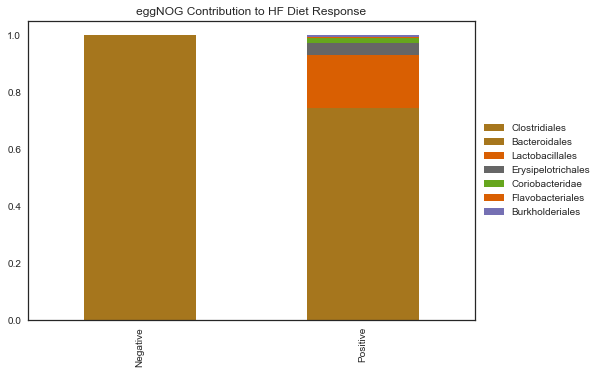

In [51]:
#Simple Plot
#my_cmap = plt.cm.get_cmap('Vega20')
plot1 = dfcategories.plot(kind='bar',stacked=True, colormap=my_cmap, title='eggNOG Contribution to HF Diet Response')
plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plot1
plt.savefig('HFDiet_InitialTime_order(piscore1).pdf',bbox_inches="tight")

### Scatterplots

df_sub = df_sig[df_sig['eggNOG_Code'] == 'I']
df_sub = df_sig[df_sig['species'] == 'Lactococcus lactis']
df_sub = df[df['Protein_y'] == 'Flagellin and related hook-associated proteins']
df_sub = df_sig[df_sig['Protein_y'] == 'Flagellin and related hook-associated proteins']
df_sub = df[df['Description'] == 'Carbohydrate transport and metabolism']
df_sub = df_sig[df_sig['eggNOG Functional Assignment'] == 'G']

In [4]:
#df_sig.to_csv('Initial_Significant.csv')
df = pd.read_csv('./HFDiet_CommonReps_SplitTaxa_Funcs.csv', index_col = 'datarest$ProteinID')
df2 = pd.read_csv('Responders_InitialTime_piscores.csv', index_col = 'datarest$ProteinID')

In [23]:
#df_sub = df[df['Protein_y'] == 'Flagellin and related hook-associated proteins']
df_sub = df[df['Description'] == 'Carbohydrate transport and metabolism']
#df_sub = df[df['Description'] == 'Posttranslational modification, protein turnover, chaperones ']
df_sub


,Unnamed: 0,HF_1,LI_1,HI_5,LF_1,HI_2,LF_4,HF_4,LF_5,LI_4,...,family,genus,species,9,COG,Protein_y,eggNOG_Code,eggNOG Functional Assignment,eggNOG Subgroup,Description
datarest$ProteinID,,,,,,,,,,,,,,,,,,,,,
1-1_GL0002373,2,317.722006,271.199204,170.773049,294.142885,151.685580,170.906741,143.606026,229.933479,157.239228,...,NaN,NaN,NaN,NaN,COG0395,"ABC-type sugar transport system, permease comp...",G,G,Metabolism,Carbohydrate transport and metabolism
1-1_GL0002951,3,31.558414,165.595442,120.241091,49.007663,391.914171,25.204066,30.793588,51.494542,96.865592,...,NaN,NaN,NaN,NaN,COG1653,"ABC-type sugar transport system, periplasmic c...",G,G,Metabolism,Carbohydrate transport and metabolism
1-1_GL0045555,11,209.481760,56.074685,41.675606,202.734393,77.235259,852.673918,778.023276,42.768972,33.839940,...,NaN,NaN,NaN,NaN,COG0395,"ABC-type sugar transport system, permease comp...",G,G,Metabolism,Carbohydrate transport and metabolism
1-1_GL0131432,20,80.838128,105.526407,173.466265,84.941828,563.835613,25.427071,56.061678,63.950981,127.639171,...,NaN,NaN,NaN,NaN,COG0574,Phosphoenolpyruvate synthase/pyruvate phosphat...,G,G,Metabolism,Carbohydrate transport and metabolism
1-2_GL0069233,28,35.837735,333.368498,208.949113,77.965165,138.347952,56.947721,90.852505,77.131672,246.374946,...,NaN,NaN,NaN,NaN,COG0058,Glucan phosphorylase,G,G,Metabolism,Carbohydrate transport and metabolism
1-2_GL0094249,30,113.056010,150.205301,254.819645,36.455077,124.127070,159.271537,87.052007,58.763140,174.976301,...,NaN,NaN,NaN,NaN,COG2723,Beta-glucosidase/6-phospho-beta-glucosidase/be...,G,G,Metabolism,Carbohydrate transport and metabolism
1-4_GL0013595,36,161.011136,263.564065,176.412660,138.464234,151.859918,90.508204,144.495694,71.373718,215.714110,...,NaN,NaN,NaN,NaN,COG3839,"ABC-type sugar transport systems, ATPase compo...",G,G,Metabolism,Carbohydrate transport and metabolism
1-4_GL0075397,40,94.883585,155.659045,286.801959,4.651374,164.582326,134.010706,72.593128,97.827430,267.685914,...,NaN,NaN,NaN,NaN,COG3717,5-keto 4-deoxyuronate isomerase,G,G,Metabolism,Carbohydrate transport and metabolism
11_GL0036637,46,151.543094,79.264235,70.148331,264.237239,68.233208,132.584725,665.888917,530.011629,56.063993,...,NaN,NaN,NaN,NaN,COG3250,Beta-galactosidase/beta-glucuronidase,G,G,Metabolism,Carbohydrate transport and metabolism


In [24]:
#Use this to subset out the proteins of interest from a separate dataframe
df_sub = df_sub[df_sub.index.isin(list(df2[abs(df2['High Response Final/Low Response Final pi score']) > 1].index))]

In [244]:
df_sub.to_csv('./MolecularChaperones_InitialTimepoint.csv')

In [245]:
df_sub = df_sub[df_sub['High Response Final/Low Response Final pi score'] > 1]

KeyError: 'High Response Final/Low Response Final pi score'

In [264]:
df_sub['Protein_y']

datarest$ProteinID
20_GL0075390            Phosphoenolpyruvate synthase/pyruvate phosphat...
1-1_GL0096133           Putative N-acetylmannosamine-6-phosphate epime...
11_GL0148287            ABC-type sugar transport systems, permease com...
4-7_GL0035599           ABC-type sugar transport system, periplasmic c...
MH-6-4_GL0148224        Phosphotransferase system, mannose/fructose/N-...
1-2_GL0056517                     L-fucose isomerase and related proteins
MH-6-5_GL0165097                            Glucose-6-phosphate isomerase
11_GL0126288                            Transketolase, C-terminal subunit
17_GL0044669            ABC-type sugar transport system, periplasmic c...
17_GL0078467                                ADP-glucose pyrophosphorylase
2-1_GL0098296                                 Alpha-L-arabinofuranosidase
4-2_GL0002041           ABC-type sugar transport system, periplasmic c...
S-Fe20_GL0128893        Ribulose-5-phosphate 4-epimerase and related e...
11_GL0101033       

In [25]:
columns = ['HF_1', 'HF_2', 'HF_4', 'HF_5', 'HI_1', 'HI_2', 'HI_4', 'HI_5','LF_1', 'LF_2', 'LF_4', 'LF_5', 'LI_1', 'LI_2', 'LI_4', 'LI_5','order','Protein_y']

In [26]:
df_sub2 = df_sub[columns]
df_sub2

,HF_1,HF_2,HF_4,HF_5,HI_1,HI_2,HI_4,HI_5,LF_1,LF_2,LF_4,LF_5,LI_1,LI_2,LI_4,LI_5,order,Protein_y
datarest$ProteinID,,,,,,,,,,,,,,,,,,
2-3_GL0008792,17.020028,4.283551,7.028764,8.926967,191.517367,162.615250,210.411135,31.200682,41.855314,103.271965,5.016987,28.208303,269.574913,452.832614,146.989808,777.563871,NaN,"ABC-type sugar transport system, permease comp..."
20_GL0075390,100.959703,84.923028,69.989098,72.161070,163.730078,637.024358,602.276003,165.671857,86.866441,154.843893,38.338771,79.399558,125.615435,269.279385,122.565035,113.395539,NaN,Phosphoenolpyruvate synthase/pyruvate phosphat...
3-1_GL0078921,827.808599,471.920081,189.878585,87.870670,103.470293,80.685485,111.335467,89.904527,389.752077,91.930853,370.282027,414.171202,130.243475,215.680025,238.165536,199.653050,NaN,"Sugar kinases, ribokinase family"
3-8_GL0034542,59.051160,72.206134,171.620969,170.127914,68.561908,35.439727,65.496106,43.364194,88.516415,201.461017,64.644978,164.075979,119.011290,145.216876,148.858199,748.493537,NaN,Beta-galactosidase/beta-glucuronidase
4-8_GL0072953,36.927791,143.995065,33.507184,60.706657,47.833297,135.653832,185.478553,34.392996,62.942357,137.326924,33.851896,123.964754,100.631392,177.679579,315.499955,710.761629,NaN,"ABC-type sugar transport system, periplasmic c..."
5-7_GL0042518,14.607176,69.226239,11.769622,38.771617,69.316242,14.216359,76.294657,112.380713,25.479063,118.221428,4.807622,24.696316,11.497507,664.043762,566.284255,279.476578,NaN,"ABC-type sugar transport system, periplasmic c..."
S-Fe7_GL0132987,68.464756,103.238844,216.670227,372.039715,65.882070,39.620312,53.718493,110.157490,120.816152,276.661902,80.653178,204.741457,111.144631,170.231245,166.883736,476.504700,NaN,Beta-galactosidase/beta-glucuronidase
1-1_GL0096133,254.340791,309.681721,521.329862,1336.620322,15.907759,65.201815,66.699387,21.236154,458.250233,530.287527,589.781384,534.581810,13.501893,28.092175,13.591103,11.171764,NaN,Putative N-acetylmannosamine-6-phosphate epime...
10_GL0023280,183.146300,25.355838,108.697610,49.759639,69.341165,183.884743,216.904073,66.341612,224.825255,137.678290,252.069611,142.283452,243.888344,661.294519,214.346208,633.686036,NaN,"ABC-type sugar transport system, periplasmic c..."


In [27]:
df_sub2.columns = ['High Responder, Final Day','High Responder, Final Day','High Responder, Final Day','High Responder, Final Day','High Responder, Initial Day','High Responder, Initial Day','High Responder, Initial Day','High Responder, Initial Day','Low Responder, Final Day','Low Responder, Final Day','Low Responder, Final Day','Low Responder, Final Day','Low Responder, Initial Day','Low Responder, Initial Day','Low Responder, Initial Day','Low Responder, Initial Day','order', 'Protein_y']
df_sub2

,"High Responder, Final Day","High Responder, Final Day","High Responder, Final Day","High Responder, Final Day","High Responder, Initial Day","High Responder, Initial Day","High Responder, Initial Day","High Responder, Initial Day","Low Responder, Final Day","Low Responder, Final Day","Low Responder, Final Day","Low Responder, Final Day","Low Responder, Initial Day","Low Responder, Initial Day","Low Responder, Initial Day","Low Responder, Initial Day",order,Protein_y
datarest$ProteinID,,,,,,,,,,,,,,,,,,
2-3_GL0008792,17.020028,4.283551,7.028764,8.926967,191.517367,162.615250,210.411135,31.200682,41.855314,103.271965,5.016987,28.208303,269.574913,452.832614,146.989808,777.563871,NaN,"ABC-type sugar transport system, permease comp..."
20_GL0075390,100.959703,84.923028,69.989098,72.161070,163.730078,637.024358,602.276003,165.671857,86.866441,154.843893,38.338771,79.399558,125.615435,269.279385,122.565035,113.395539,NaN,Phosphoenolpyruvate synthase/pyruvate phosphat...
3-1_GL0078921,827.808599,471.920081,189.878585,87.870670,103.470293,80.685485,111.335467,89.904527,389.752077,91.930853,370.282027,414.171202,130.243475,215.680025,238.165536,199.653050,NaN,"Sugar kinases, ribokinase family"
3-8_GL0034542,59.051160,72.206134,171.620969,170.127914,68.561908,35.439727,65.496106,43.364194,88.516415,201.461017,64.644978,164.075979,119.011290,145.216876,148.858199,748.493537,NaN,Beta-galactosidase/beta-glucuronidase
4-8_GL0072953,36.927791,143.995065,33.507184,60.706657,47.833297,135.653832,185.478553,34.392996,62.942357,137.326924,33.851896,123.964754,100.631392,177.679579,315.499955,710.761629,NaN,"ABC-type sugar transport system, periplasmic c..."
5-7_GL0042518,14.607176,69.226239,11.769622,38.771617,69.316242,14.216359,76.294657,112.380713,25.479063,118.221428,4.807622,24.696316,11.497507,664.043762,566.284255,279.476578,NaN,"ABC-type sugar transport system, periplasmic c..."
S-Fe7_GL0132987,68.464756,103.238844,216.670227,372.039715,65.882070,39.620312,53.718493,110.157490,120.816152,276.661902,80.653178,204.741457,111.144631,170.231245,166.883736,476.504700,NaN,Beta-galactosidase/beta-glucuronidase
1-1_GL0096133,254.340791,309.681721,521.329862,1336.620322,15.907759,65.201815,66.699387,21.236154,458.250233,530.287527,589.781384,534.581810,13.501893,28.092175,13.591103,11.171764,NaN,Putative N-acetylmannosamine-6-phosphate epime...
10_GL0023280,183.146300,25.355838,108.697610,49.759639,69.341165,183.884743,216.904073,66.341612,224.825255,137.678290,252.069611,142.283452,243.888344,661.294519,214.346208,633.686036,NaN,"ABC-type sugar transport system, periplasmic c..."


In [32]:
df_sub2.to_csv('./AllSigCarbohydrateMetabolism.csv')

In [28]:
len(df_sub2['Protein_y'])

110

In [29]:
idsvars = ['order', 'Protein_y']
df_sub2_melt = pd.melt(df_sub2, id_vars = idsvars)
df_sub2_melt

,order,Protein_y,variable,value
0,NaN,"ABC-type sugar transport system, permease comp...","High Responder, Final Day",17.020028
1,NaN,Phosphoenolpyruvate synthase/pyruvate phosphat...,"High Responder, Final Day",100.959703
2,NaN,"Sugar kinases, ribokinase family","High Responder, Final Day",827.808599
3,NaN,Beta-galactosidase/beta-glucuronidase,"High Responder, Final Day",59.051160
4,NaN,"ABC-type sugar transport system, periplasmic c...","High Responder, Final Day",36.927791
5,NaN,"ABC-type sugar transport system, periplasmic c...","High Responder, Final Day",14.607176
6,NaN,Beta-galactosidase/beta-glucuronidase,"High Responder, Final Day",68.464756
7,NaN,Putative N-acetylmannosamine-6-phosphate epime...,"High Responder, Final Day",254.340791
8,NaN,"ABC-type sugar transport system, periplasmic c...","High Responder, Final Day",183.146300
9,NaN,Alpha-galactosidase,"High Responder, Final Day",32.868191


In [30]:
order = ['Low Responder, Initial Day','High Responder, Initial Day', 'Low Responder, Final Day', 'High Responder, Final Day']

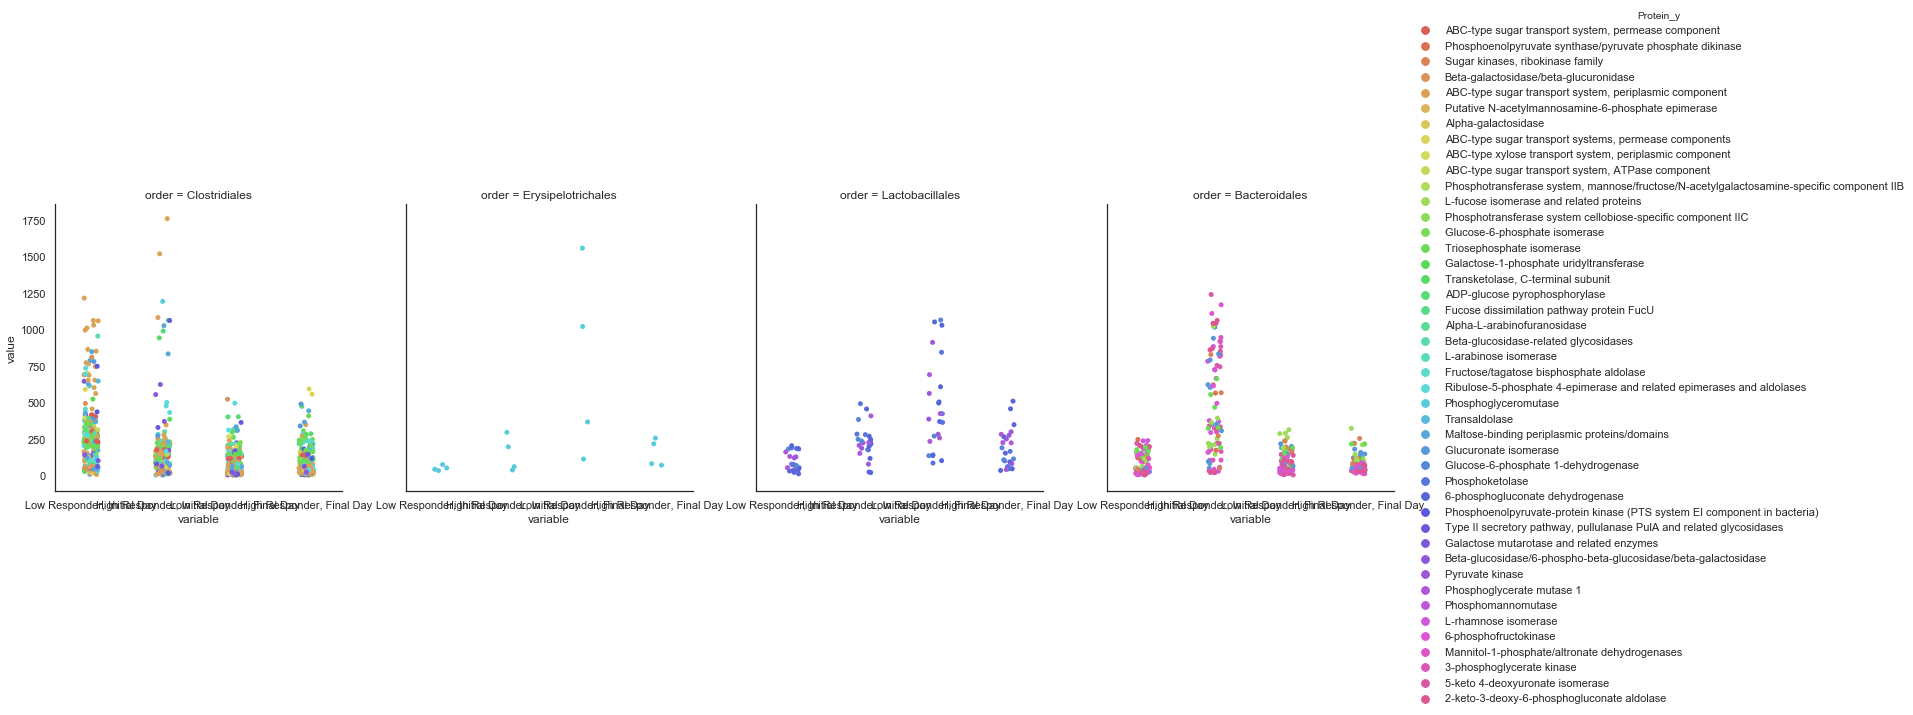

In [31]:
#fig, ax = plt.subplots()
#sns.violinplot(x = "Sample", y = 'value', data = df_sub2_melt, palette = sns.color_palette("Paired"))
#sns.swarmplot(x = 'variable', y = "value", hue = "Protein_y", order = order, alpha=1, 
              #data = df_sub2_melt, palette=sns.hls_palette(12), hue = 'order')
#sns.boxplot(x="variable", y="value", data=df_sub2_melt, order = order, color='w',hue = 'order')
sns.catplot(x = 'variable', y = "value", hue = "Protein_y", order = order, alpha=1, 
              data = df_sub2_melt, palette=sns.hls_palette(47), col = 'order')
#sns.catplot(x = 'variable', y = "value", order = order, alpha=1, color = 'w',
             # data = df_sub2_melt, palette=sns.hls_palette(12), col = 'order', kind='box')


#plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
fig.autofmt_xdate(rotation = -90, ha = 'center')
plt.savefig("./SigAllInitial_CarbohydratesbyOrder.pdf",bbox_inches='tight')

In [287]:
df_sub2 = df_sub[columns]
df_sub2

,HF_1,HF_2,HF_4,HF_5,HI_1,HI_2,HI_4,HI_5,LF_1,LF_2,LF_4,LF_5,LI_1,LI_2,LI_4,LI_5,order,Protein_y
datarest$ProteinID,,,,,,,,,,,,,,,,,,
20_GL0075390,100.959703,84.923028,69.989098,72.161070,163.730078,637.024358,602.276003,165.671857,86.866441,154.843893,38.338771,79.399558,125.615435,269.279385,122.565035,113.395539,NaN,Phosphoenolpyruvate synthase/pyruvate phosphat...
1-1_GL0096133,254.340791,309.681721,521.329862,1336.620322,15.907759,65.201815,66.699387,21.236154,458.250233,530.287527,589.781384,534.581810,13.501893,28.092175,13.591103,11.171764,NaN,Putative N-acetylmannosamine-6-phosphate epime...
11_GL0148287,6.011716,143.503988,7.843323,25.693149,1390.583666,165.401953,121.356422,2.316477,10.725377,32.208655,0.516650,14.618177,5.648944,30.226938,35.831740,30.960859,NaN,"ABC-type sugar transport systems, permease com..."
4-7_GL0035599,9.079087,92.491904,12.578168,33.927840,1430.414464,132.739101,74.483795,7.621542,13.227325,64.992477,8.531934,14.033198,29.265977,70.043595,81.977728,55.334480,NaN,"ABC-type sugar transport system, periplasmic c..."
MH-6-4_GL0148224,1146.724469,750.056844,224.139891,219.960343,21.284224,29.397875,37.628089,25.704291,560.531234,752.981831,805.483967,1032.785946,8.625307,19.038048,13.275677,15.991005,NaN,"Phosphotransferase system, mannose/fructose/N-..."
1-2_GL0056517,304.114048,107.564465,416.797654,1192.175322,45.010239,176.372899,106.221748,125.960924,241.053923,319.194761,227.994841,298.139460,57.626899,29.181076,16.431942,29.026397,NaN,L-fucose isomerase and related proteins
MH-6-5_GL0165097,1640.636427,1172.165513,190.791550,129.786218,3.357330,34.319643,3.052090,21.220660,633.313497,107.093158,552.612695,502.056648,3.665724,6.904718,0.625191,0.179260,NaN,Glucose-6-phosphate isomerase
11_GL0126288,167.788434,240.868373,183.368684,109.525556,942.440701,384.815627,32.299259,122.324939,196.499057,133.328328,147.367922,153.444716,232.828369,18.590430,83.360919,25.842518,Clostridiales,"Transketolase, C-terminal subunit"
17_GL0044669,8.118784,76.527496,19.597794,42.017742,1081.986383,240.301978,345.398713,22.048132,12.545770,64.499379,16.232303,12.682586,94.460610,57.081048,120.490166,111.523447,Clostridiales,"ABC-type sugar transport system, periplasmic c..."


In [282]:
df_sub2 = df_sub[columns].T
df_sub2.columns = df_sub2.loc['Protein_y']
df_sub2.drop('Protein_y', inplace=True)


In [283]:
df_sub2['Sample'] = ['High Responder, Final Day','High Responder, Final Day','High Responder, Final Day','High Responder, Final Day','High Responder, Initial Day','High Responder, Initial Day','High Responder, Initial Day','High Responder, Initial Day','Low Responder, Final Day','Low Responder, Final Day','Low Responder, Final Day','Low Responder, Final Day','Low Responder, Initial Day','Low Responder, Initial Day','Low Responder, Initial Day','Low Responder, Initial Day']
#df_sub2.index = ['High Responder, Final Day','High Responder, Final Day','High Responder, Final Day','High Responder, Final Day','High Responder, Initial Day','High Responder, Initial Day','High Responder, Initial Day','High Responder, Initial Day','Low Responder, Final Day','Low Responder, Final Day','Low Responder, Final Day','Low Responder, Final Day','Low Responder, Initial Day','Low Responder, Initial Day','Low Responder, Initial Day','Low Responder, Initial Day', 'order', 'protein']
df_sub2

ValueError: Length of values does not match length of index

In [276]:
len(df_sub2.columns.drop_duplicates())

47

In [277]:
idsvars = ['order', 'protein']

In [280]:
?pd.melt

In [281]:
df_sub2_melt = pd.melt(df_sub2, id_vars = idsvars, value_vars = 'datarest$ProteinID')

KeyError: "None of [['order', 'protein', 'datarest$ProteinID']] are in the [columns]"

In [253]:
df_sub2_melt['value'] = pd.to_numeric(df_sub2_melt['value'])

In [254]:
df_sub2_melt.to_csv('./MetaproteomicChaperoneSubsetValuesByProtein.csv')

In [89]:
#df_sub2_melt.replace(np.nan, 'Unknown', inplace=True)

sns.violinplot(x="day", y="total_bill", data=tips, inner=None)
sns.swarmplot(x="day", y="total_bill", data=tips, color="w", alpha=.5)

In [255]:
order = ['Low Responder, Initial Day','High Responder, Initial Day', 'Low Responder, Final Day', 'High Responder, Final Day']

In [258]:
?sns.boxplot()

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


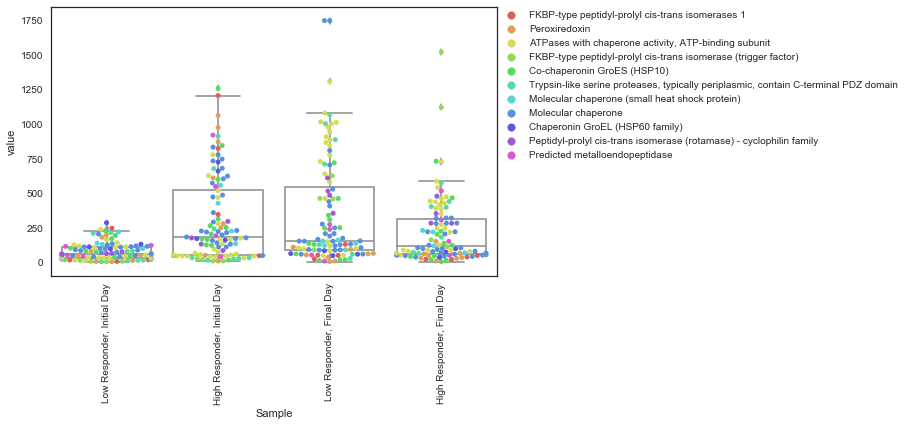

In [261]:
fig, ax = plt.subplots()
#sns.violinplot(x = "Sample", y = 'value', data = df_sub2_melt, palette = sns.color_palette("Paired"))
sns.swarmplot(x = 'Sample', y = "value", hue = "Protein_y", order = order, alpha=1, data = df_sub2_melt, palette=sns.hls_palette(12))
sns.boxplot(x="Sample", y="value", data=df_sub2_melt, order = order, color='w')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
fig.autofmt_xdate(rotation = 90, ha = 'center')
plt.savefig("./SigHighInitial_Cahperones.pdf",bbox_inches='tight')